In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

import os

from ms_stim_analysis.Analysis.utils import filter_opto_data, smooth
from ms_stim_analysis.AnalysisTables.ms_opto_stim_protocol import OptoStimProtocol
from ms_stim_analysis.AnalysisTables.decoding_tables import (
    ContinuousRippleTraversal,
    ContinuousRippleTraversalSelection,
    ContinuousRippleTraversalParams,
)
os.curdir
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1

[2025-08-28 09:21:21,194][INFO]: DataJoint 0.14.6 connected to sambray@lmf-db.cin.ucsf.edu:3306


In [3]:
# # Logging for database export. Not necessary for replication

from spyglass.common.common_usage import Export, ExportSelection

paper_key = {"paper_id": "ms_stim_analysis"}

analysis_id = "continuous_traversals"
# (ExportSelection() & {**paper_key, "analysis_id": analysis_id}).delete()

ExportSelection().start_export(**paper_key, analysis_id=analysis_id)

[09:31:10][INFO] Spyglass: Starting {'export_id': 47}


# Results


(0.0, 100.0)

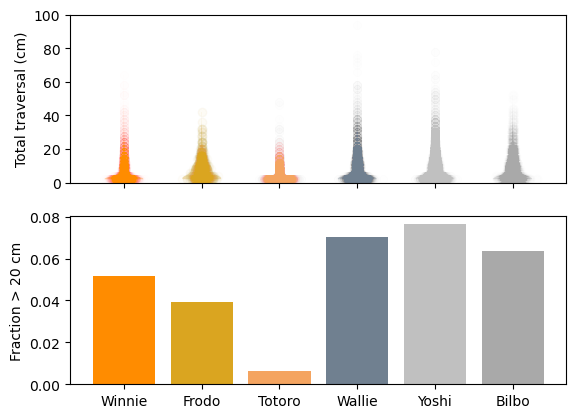

In [4]:
from ms_stim_analysis.Style.style_guide import animal_style
from ms_stim_analysis.Analysis.utils import violin_scatter

i = 0
long_thresh = 20  # in cm

data = "longest"
artifact_detection = "ms_lfp_artifact_times"

fig, ax = plt.subplots(nrows=2, sharex=True)
animal_list = ["Winnie", "Frodo", "Totoro", "Wallie", "Yoshi", "Bilbo"]
for i, animal in enumerate(animal_list):
    query = (
        ContinuousRippleTraversal()
        & f"nwb_file_name LIKE '{animal}%'"
        & f"target_interval_list_name LIKE '%{artifact_detection}'"
    )
    if not query:
        continue
    df = query.fetch_dataframe()
    if data == "total":
        val = df.total_traversal
    elif data == "longest":
        val = df.longest_traversal * 2  # (puts it in cm)
    else:
        raise ValueError("Data type not recognized")
    violin_scatter(val, color=animal_style.loc[animal, "color"], pos=i, ax=ax[0])

    fract = val > long_thresh

    ax[1].bar(i, fract.mean(), color=animal_style.loc[animal, "color"])

ax[0].set_ylabel("Total traversal (cm)")
ax[1].set_ylabel(f"Fraction > {long_thresh} cm")


ax[1].set_xticks(np.arange(i + 1))
ax[1].set_xticklabels(animal_list)
ax[0].set_ylim(0, 100)

# Plotting exemplar long traces


In [32]:
# Find good long continuous one
animal = "Totoro"
animal = "Winnie"
animal = "Yoshi"
# animal = "Wallie"

query_key = f"nwb_file_name LIKE '{animal}%'"

# query_key = dict(nwb_file_name="Totoro20220613_.nwb", pos_interval="pos 1 valid times")
query = ContinuousRippleTraversal() & query_key

longest_key = None
max_length = 0

for key in query.fetch("KEY"):
    df = (query & key).fetch1_dataframe()
    if df.longest_traversal.max() > max_length:
        max_length = df.longest_traversal.max()
        longest_key = key

query & longest_key
traversal_df = (query & longest_key).fetch1_dataframe()

/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Pl

In [33]:
Decoder = ClusterlessDecodingV1
# Decoder = SortedSpikesDecodingV1

nwb_file_name = longest_key["nwb_file_name"]
interval = longest_key["position_group_name"].strip("DLC ")
encoding_tag = ""  # "_opto_control_interval"
causal_tag = ""  # "_causal"
key = {
    "nwb_file_name": nwb_file_name,
    "position_group_name": "DLC " + interval,
    "encoding_interval": interval + encoding_tag,
}
key = (
    (Decoder() & key)
    & f"decoding_param_name LIKE '%{causal_tag}'"
    # & "sorted_spikes_group_name NOT LIKE 'manual%'"
).fetch1("KEY")

pos_df = Decoder().fetch_linear_position_info(key)
results = (Decoder() & key).fetch_results()
posterior = results.acausal_posterior.unstack("state_bins").sum("state")[0]
decode_pos = posterior.idxmax("position").values

opto_key = {
    "nwb_file_name": nwb_file_name,
    "interval_list_name": interval,
}
stim, stim_time = OptoStimProtocol().get_stimulus(opto_key)

linear_pos = pos_df["linear_position"].values

if "sorted" in Decoder.full_table_name:
    spikes = Decoder().fetch_spike_data(key)
else:
    spikes = Decoder().fetch_spike_data(key)[0]
flat_spikes = np.concatenate(spikes)
spike_inds = np.digitize(flat_spikes, pos_df.index.values)
mua = np.bincount(spike_inds, minlength=len(pos_df))
mua = smooth(mua, 5)
mua = mua / np.mean(np.diff(pos_df.index.values))
environment = Decoder().fetch_environments(key)[0]
distance_dict = environment.distance_between_nodes_

/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/spyglass/decoding/v1/core.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or 

In [34]:
from spyglass.lfp.analysis.v1.lfp_band import LFPBandV1
from spyglass.lfp.v1 import LFPV1
from spyglass.lfp.lfp_merge import LFPOutput
from spyglass.ripple.v1 import RippleTimesV1, RippleLFPSelection

LFPV1 & {"nwb_file_name": nwb_file_name, "target_interval_list_name": interval}
artifact_detection = "ms_lfp_artifact_times"
band_query = (
    LFPBandV1()
    & {
        "nwb_file_name": nwb_file_name,
        #    "target_interval_list_name": interval,
        "filter_name": "Ripple 150-250 Hz",
    }
    & "target_interval_list_name LIKE '%{}%'".format(interval)
    & f"target_interval_list_name LIKE '%{artifact_detection}%'"
)
band_query
ripple_band_df = band_query.fetch1_dataframe()

/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.2.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [35]:
state_posterior = results.acausal_posterior.unstack("state_bins").sum("position")[0]
state_posterior.shape

(605429, 2)

In [37]:
test_intervals = (
    OptoStimProtocol
    & longest_key
    & {"interval_list_name": longest_key["decoding_interval"]}
).fetch1("test_intervals")

first_test_interval = np.array([test_intervals[0]])

from spyglass.common import interval_list_contains_ind

ind_ripples = interval_list_contains_ind(
    first_test_interval, traversal_df["start_time"].values
)
traversal_df = traversal_df.iloc[ind_ripples]

[10:05:25][WARNING] Spyglass: DEPRECATION scheduled for Spyglass 0.6.0: interval_list_contains_ind
	Use Interval.contains instead


In [38]:
ripple_num = np.argsort(traversal_df.longest_traversal.values)
print(ripple_num)
# Winnie
# ripple_num = ripple_num[-3]
# ripple_num = ripple_num[-2]
# ripple_num = ripple_num[-5]
# Wallie
# ripple_num = ripple_num[-1]
# ripple_num = 294
# Yoshi
# ripple_num = ripple_num[-1]
ripple_num = ripple_num[-2]
# ripple_num = ripple_num[-3]


# ripple_num = ripple_num[-7]
# print(traversal_df.iloc[ripple_num])
st = traversal_df.iloc[ripple_num].start_time
en = traversal_df.iloc[ripple_num].end_time
# traversal_df.iloc[ripple_num]
# longest_key

[  9  10  13 105 108 107 100  21  97  96  80  91  88  27 102 101  35  94
  57  54  67  68   4 115  61   2  45  46  15  17  93  92  98  18  60 114
  56  69  32  26  74  71 113   6  37  82  55  76  65  83  63  58  81  95
  14  23  87  72   1  59  47  66  70  90  25  75 112  73  41 110  99  38
  39  51  78 106 109  36 103  20  33  29  30 117  62  53 116 119  77  43
   3  52  40   8   7  24  16  48  31  44  64 121  22  84  85 118 122  19
 120  34 111   0  12  11  86  49  28 104  50   5  79  42  89]


[71909 71910 71911 71912 71913 71914 71915 71916 71917 71918 71919 71920
 71921 71922 71923 71924 71925 71926 71927 71928 71929 71930 71931 71932
 71933 71934 71935 71936 71937 71938 71939 71940 71941 71942 71943 71944
 71945 71946 71947 71948 71949 71950 71951 71952 71953 71954 71955 71956
 71957 71958 71959 71960 71961 71962 71963 71964 71965 71966 71967 71968
 71969 71970 71971 71972 71973 71974 71975 71976 71977 71978 71979 71980
 71981 71982 71983 71984 71985 71986 71987 71988 71989 71990 71991 71992
 71993 71994 71995 71996 71997 71998 71999 72000 72001 72002 72003 72004
 72005 72006 72007 72008 72009 72010 72011 72012 72013 72014 72015 72016
 72017 72018 72019 72020 72021 72022 72023 72024 72025 72026 72027 72028
 72029 72030 72031 72032 72033 72034 72035 72036 72037 72038 72039 72040
 72041 72042 72043 72044 72045 72046 72047 72048 72049 72050 72051 72052
 72053 72054 72055 72056 72057 72058 72059 72060 72061 72062 72063 72064
 72065 72066 72067 72068 72069 72070 72071 72072 72

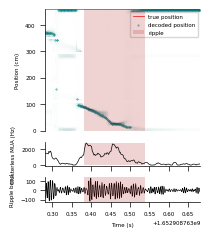

In [39]:
# pos_df
posterior.shape, pos_df.shape

# t0 = pos_df.index.values[0] - 9 * 60 + 30.4
t0 = 0

t_rng = (st - 0.1, st + 0.3)
# t_rng = (st - 0.1, st + 0.5)

plt.rcParams.update({"font.size": 4})
lw = 0.5
plt.rcParams.update({"lines.linewidth": lw})
plt.rcParams.update({"axes.linewidth": lw})
plt.rcParams["xtick.major.width"] = lw  # Width of major x-ticks
plt.rcParams["ytick.major.width"] = lw
fig, ax = plt.subplots(
    nrows=3, figsize=(2, 2.5), sharex=False, height_ratios=[20, 4, 4]
)
# ax = [ax]
ind = np.where(
    (pos_df.index.values >= t0 + t_rng[0]) & (pos_df.index.values < t0 + t_rng[1])
)[0]

ind

print(ind)
# ax[0].imshow(
#     posterior[ind].T,
#     aspect=0.0005,
#     extent=[*t_rng, results.position.max() + results.position.min() + 0, 0],
#     cmap="bone_r",
#     clim=[0, 0.05],
#     zorder=-1,
# )
t_plot = pos_df.index[ind].values  # - t0
xx, yy = np.meshgrid(t_plot, results.position)
pos_val = results.position.values
pos_val = pos_val[: pos_val.shape[0] // 2]
XX, YY = np.meshgrid(t_plot, pos_val)
clim = None
ax[0].pcolormesh(
    XX,
    YY,
    posterior[ind].T,
    cmap="bone_r",
    shading="nearest",
    clim=clim,
    rasterized=True,
)
# ax[0].scatter(t_plot, linear_pos[ind], color="r", s=.15)

ax[0].plot(t_plot, linear_pos[ind], "r", label="true position")
ax[0].scatter(t_plot, decode_pos[ind], color="teal", s=0.1, label="decoded position")


ax[1].plot(t_plot, mua[ind], "k")

# ripples
ind_ripple = np.where(
    np.logical_and(
        (ripple_band_df.index.values >= t0 + t_rng[0]),
        (ripple_band_df.index.values < t0 + t_rng[1]),
    )
)[0]
t_rip = ripple_band_df.index[ind_ripple]
y_rip = ripple_band_df.iloc[ind_ripple].values[:, 2].astype(float)
gaps = np.where(np.diff(t_rip) > 0.01)[0] + 1
y_rip[gaps] = 1.0 * np.nan
ax[2].plot(t_rip, y_rip, "k")
ax[2].set_ylabel("Ripple band")
rip_lo = np.nanmin(y_rip) * 1.05
rip_hi = np.nanmax(y_rip) * 1.05
ax[2].fill_between(
    [st, en], rip_lo, rip_hi, facecolor="firebrick", alpha=0.2, zorder=10
)
ax[2].set_ylim(rip_lo, rip_hi)


ax[0].fill_between(
    [st, en],
    0,
    np.nanmax(linear_pos),
    facecolor="firebrick",
    alpha=0.2,
    zorder=10,
    label="ripple",
)
ax[1].fill_between(
    [st, en], 0, np.nanmax(mua[ind]), facecolor="firebrick", alpha=0.2, zorder=0
)

ax[-1].set_xlabel("Time (s)")
ax[0].set_ylabel("Position (cm)")
# ax[0].set_title(f"{nwb_file_name}, {interval}, ripple {ripple_num}")
ax[1].set_ylabel("Clusterless MUA (Hz)")
ax[0].legend()

for a in ax:
    a.spines[["top", "right"]].set_visible(False)
    a.set_xlim(t_rng)
ax[0].spines[["bottom"]].set_visible(False)
ax[0].set_xticks([])
# ax[0].set_ylim(0, 100)
plt.rcParams["svg.fonttype"] = "none"

fig.savefig(
    f"../Figures/Fig_5/Fig_5a_{nwb_file_name}_{interval}_ripple_{ripple_num}_rasterized.svg"
)